In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, ConstantKernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


#Import dataset
df = pd.read_pickle('DoE_results_3d_1k.pkl')
points_df = df['points']

#Eliminate all NaN output values 
points_df_1 = points_df[(points_df['sigma_crit'] > 0) & (points_df['energy'] >= 0)]
sigma_crit_1 = points_df_1['sigma_crit']
energy_1 = points_df_1['energy']

#Find the quartiles to eliminate outliers
q1_s = np.percentile(sigma_crit_1,25.0)
q3_s = np.percentile(sigma_crit_1, 75.0)
q1_e = np.percentile(energy_1,25.0)
q3_e = np.percentile(energy_1, 75.0)

#Define the highest point which is not considered an outlier
high_s = q3_s + 1.5*(q3_s-q1_s)
high_e = q3_e + 1.5*(q3_e-q1_e)

#Eliminate outliers
points_df_2 = points_df[(points_df['sigma_crit'] < high_s) & (points_df['energy'] < high_e)]

#Convert the columns to arrays
RD = points_df_2['ratio_d'].to_numpy()
RP = points_df_2['ratio_pitch'].to_numpy()
RT = points_df_2['ratio_top_diameter'].to_numpy()
S  = points_df_2['sigma_crit'].to_numpy()
E  = points_df_2['energy'].to_numpy()

# xx1, xx2, xx3 = np.meshgrid(RD, RP, RT)
# input_points = np.array([xx1, xx2, xx3])
# yy1, yy2 = np.meshgrid(S, E)
# output_points = np.array([yy1, yy2])

# X_data = xx1, xx2, xx3
# y_data = yy1, yy2


#Make a training set for all inputs and outputs
train_size = 0.75
RD_train,RD_test,RP_train,RP_test,RT_train,RT_test,S_train,S_test,E_train,E_test=train_test_split(RD,RP,RT,S,E,train_size=train_size)


In [2]:
input1 = RD
input2 = RP
input3 = RT
output = S

X_data = np.array([input1,input2,input3]).reshape(3,-1).T
Y_data = np.array([output]).reshape(-1,1)
xx1, xx2,xx3 = np.meshgrid(input1,input2,input3, sparse=True)
yy1 = output

train_size= 0.75
X_Train,X_Test,Y_Train,Y_Test=train_test_split(X_data, Y_data, train_size=train_size)


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, ConstantKernel

kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) # This is the standard RBF kernel
kernel = 1.0 * RBF(10, (1e-2, 1e2)) # Same kernel as above
                                    #(scikit-learn assumes constant
                                    # variance if you just write RBF
                                    # without the constant kernel or
                                    # without multiplying by 1.0)

# Other examples of kernels:
#kernel = ExpSineSquared(length_scale=3.0, periodicity=3.14,
#                       length_scale_bounds=(0.1, 10.0),
#                       periodicity_bounds=(0.1, 10)) * RBF(3.0, (1e-2, 1e2))
#kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2),nu=1.5)
                
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, n_restarts_optimizer=10) # using a small alpha

# Fit to data using Maximum Likelihood Estimation of the parameters
gp_model.fit(X_Train, Y_Train)

y_data_pred, sigma_data_pred = gp_model.predict(X_data, return_std=True) # also output the uncertainty (standard deviation)

y_test_pred, sigma_test_pred = gp_model.predict(X_Test, return_std=True) # For error metrics


C:\Programs\Anaconda3\envs\MLenv3\lib\site-packages\sklearn\gaussian_process\_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Programs\Anaconda3\envs\MLenv3\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Programs\Anaconda3\envs\MLenv3\lib\site-packages\sklearn\gaussian_process\_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [3]:
yy1 = np.reshape(yy1, np.shape(xx1))
yy1_data_pred = np.reshape(y_data_pred,np.shape(xx1))
nsamples, nx, ny = yy1.shape
d2_yy1 = yy1.reshape((nsamples,nx*ny))

d2_yy1_data_pred = yy1_data_pred.reshape((nsamples,nx*ny))
mse_value = mean_squared_error(d2_yy1.T, d2_yy1_data_pred.T)
r2_value  = r2_score(d2_yy1.T, d2_yy1_data_pred.T)
print('MSE =', mse_value)
print('R2 score =', r2_value)

MSE = 1.9533953700869826
R2 score = 0.9933158997006534


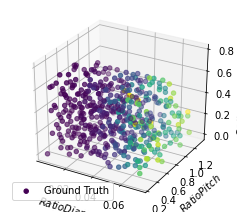

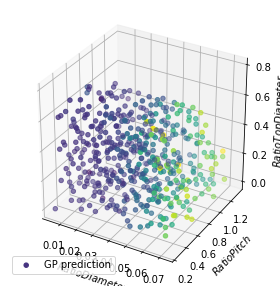

In [4]:
fig1 = plt.figure(figsize=plt.figaspect(2.0))
#
# Subplot 1 (top) of Figure 1: ground truth
ax1 = fig1.add_subplot(2, 1, 1, projection='3d')
#
# Don't forget that for a Surface plot we need the data
# coming out of meshgrid not in the format of X_data (!)
#
surf = ax1.scatter(xx1, xx2,xx3,c= yy1,label ="Ground Truth")

# Create axis labels and title:
ax1.set_xlabel('$Ratio Diameter$')
ax1.set_ylabel('$Ratio Pitch$')
ax1.set_zlabel('$Ratio Top Diameter$')
# Subplot 2 (bottom) of Figure 1
#ax2 = fig1.add_subplot(2, 1, 2, projection='3d')
#
ax1.legend(loc='lower left')
fig2 = plt.figure(figsize=plt.figaspect(2.0))
#
# Subplot 1 (top) of Figure 1: ground truth
ax2 = fig2.add_subplot(2, 1, 1, projection='3d')
surf = ax2.scatter(xx1, xx2,xx3,c= yy1_data_pred,label="GP prediction")
# Create axis labels and title:
ax2.set_xlabel('$Ratio Diameter$')
ax2.set_ylabel('$Ratio Pitch$')
ax2.set_zlabel('$Ratio Top Diameter$')
ax2.legend(loc='lower left')
plt.tight_layout()